# MSc Simple Multi-Objective AutoML Pipeline

First I will look at 2 sets of data, 1 binary classification and one multiclass. I will do a complete pipeline and evaluation that will later be automated. That pipeline will include:

* Data Preprocessing
* Model Training
* Hyperparameter optimization.
* Model Evaluation with Accuracy
* Model Evaluation with Interpretability (specified metrics)
* Incorporating into a ranking function for model selection

Each automation will be constrained.

<img src="images\Pipeline.png"/>

Algorithms that will be used for modelling will be limited to:

1. Logistic Regression
2. Decision Trees
3. Random Forest
4. LightGBM
5. SVM

## Preprocessing Data

This study will assume that datasets input into the automated pipeline will be reasonably clean and representative, as commonly provided by machine learning dataset repositories. Therefore extensive data cleaning and feature engineering are considered outside the scope of this work.

In [ ]:
# Importing the libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Import the algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

Telco Customer Churn:

https://www.kaggle.com/datasets/blastchar/telco-customer-churn 

In [7]:
# Import dataset
churn_data = pd.read_csv("Datasets/Telco-Customer-Churn.csv")
print(type(churn_data))

<class 'pandas.core.frame.DataFrame'>


In [8]:
# Check the shape of the dataframe
churn_data.shape

(7043, 21)

In [9]:
# Inspect the datatype of each feature and if there are any missing values
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
# Summary statistics
churn_data.describe(include='object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [11]:
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Quick things to realise when inspecting the data:

* The ID column will be useless in modelling and will need to be dropped consistently accross datasets, it can be seen that the **number of unique values = number of rows** therefore some logic may be implemented to decide when to drop.

* The column "TotalCharges" has 6531 unique values, after inspection, these are numerical charge values stored as strings, in the dtype object. it would be good to process these in the pipeline.

To maintain a simple and generic preprocessing pipeline, features with type object can be treated as categorical variables. It can be implemented that features with more than 20 distinct values can be dropped, as this represents high-cardinality and can negatively impact interpretability and explanation stability. No attempt will be made to coerce these features to numeric values, as this would require dataset specific cleaning logic and would defeat the point of implementing this across datasets.

In [12]:
# creating a function for identifying data types of each column for preprocessing, splitting them into groups

def get_feature_groups(data):

    categorical_columns = data.select_dtypes(include=["object", "string", "category"]).columns #detect all categorical column labels
    numeric_columns = data.select_dtypes(include="number").columns #detect all numerical column labels 
    bool_columns = data.select_dtypes(include="bool").columns #detect possible boolean columns

    numeric_columns = numeric_columns.union(bool_columns).tolist() #merge boolean in with numeric as they are 0 and 1 representations

    high_cardinality = data[categorical_columns].nunique() > 20 #isolate high cardinality features

    #columns_to_drop = high_cardinality[high_cardinality].index.tolist() #create a column to drop list
    categorical_columns = high_cardinality[~high_cardinality].index.tolist() #dropping high cardinality features from categorical list
    
    return numeric_columns, categorical_columns, #columns_to_drop


By creating a list for each type of variable, this will lead into transforming the columns and preparing for a scikit learn pipeline.

In [13]:
# Split the data into training and test sets
y = churn_data["Churn"]
X = churn_data.drop("Churn", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((5634, 20), (5634,), (1409, 20), (1409,))

In [14]:
numerical_columns, categorical_columns = get_feature_groups(X_train)

In [15]:
print(numerical_columns)
print(categorical_columns)

['SeniorCitizen', 'tenure', 'MonthlyCharges']
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [16]:
# Create a column transformer

preprocesser = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ],
    remainder = "drop",
    n_jobs=-1 # enable use of all cpu threads locally
)

Column transformer will help to transform the numerical features and the categorical features.

In [17]:
# Create a dictionary of models to iterate over

models = {
    "logreg": LogisticRegression(),
    "dt": DecisionTreeClassifier(),
    "rf": RandomForestClassifier(),
    "svm": LinearSVC(),
    "lgb": LGBMClassifier(),
}

In [18]:
# Create an iterative pipeline

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocess", preprocesser),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)

    results[name] = score

[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418


c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [19]:
print(results)

{'logreg': 0.8211497515968772, 'dt': 0.7154009936124911, 'rf': 0.7799858055358411, 'svm': 0.8183108587650816, 'lgb': 0.7984386089425124}


While the previous pipeline it clean, if cross validation is used feature selection based on X_train will cause data leakage for each fold as the validation set would have been used to make transformations on the training data. Hence we want to implement feature selection and preprocessing of data for each training fold.

In [20]:
# Split the data into training and test sets

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(churn_data["Churn"]) # encode category labels
X = churn_data.drop("Churn", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5634, 20), (5634,), (1409, 20), (1409,))

In [21]:
# Create a transformer class to group features in first step of a pipeline

from sklearn.base import BaseEstimator, TransformerMixin

class GroupFeatures(BaseEstimator, TransformerMixin):

    # Constructor method
    def __init__(self, max_unique=20):
        self.max_unique = max_unique

    #Fit method learns column groupings and detects high cardinality --> metadata for future steps
    def fit(self, X, y=None):
        categorical = X.select_dtypes(include=["object", "string", "category"])
        numeric = X.select_dtypes(include="number")
        boolean = X.select_dtypes(include="bool")

        high_cardinality = categorical.nunique() > self.max_unique #Detects high cardinality above maximum value specified

        self.numeric_columns_ = numeric.columns.union(boolean.columns).tolist() #Creates numerical column list
        self.categorical_columns_ = high_cardinality[~high_cardinality].index.tolist() #Creates categorical column list - high cardinality features

        self.keep_columns_ = self.numeric_columns_ + self.categorical_columns_

        return self

    # passes through the data untransformed 
    def transform(self, X):
        return X[self.keep_columns_]

In [22]:
# ColumnTransformer for feature preprocessing
from sklearn.compose import make_column_selector

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), make_column_selector(dtype_include="number")), 
        ("cat", OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=["object", "string", "category"])),
    ],
    remainder="drop"
)

In [23]:
# Implement Cross-Validation Evaluation

from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

for name, model in models.items():

    # Create pipeline that include GroupFeatures in first step
    pipeline = Pipeline([
    ("features", GroupFeatures(max_unique=20)),
    ("preprocess", preprocessor),
    ("model", model)
    ])

    cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True
    )

    results[name] = cv_results

[LightGBM] [Info] Number of positive: 1197, number of negative: 3310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265587 -> initscore=-1.017130
[LightGBM] [Info] Start training from score -1.017130
[LightGBM] [Info] Number of positive: 1197, number of negative: 3310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 44
[LightGBM] [Info] [binary:

c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1197, number of negative: 3310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265587 -> initscore=-1.017130
[LightGBM] [Info] Start training from score -1.017130
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 44
[LightGBM] [Info] [binary:

c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1197, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 4508, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265528 -> initscore=-1.017432
[LightGBM] [Info] Start training from score -1.017432


c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [24]:
results['logreg']['test_accuracy']

array([0.78881988, 0.81011535, 0.78615794, 0.80834073, 0.79928952])

In [25]:
results['logreg']

{'fit_time': array([0.04179358, 0.03705931, 0.04416966, 0.04293275, 0.04136109]),
 'score_time': array([0.02503228, 0.00995207, 0.01978135, 0.03118587, 0.02864194]),
 'estimator': [Pipeline(steps=[('features', GroupFeatures()),
                  ('preprocess',
                   ColumnTransformer(transformers=[('num', StandardScaler(),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000002DD96B4E650>),
                                                   ('cat',
                                                    OneHotEncoder(handle_unknown='ignore'),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000002DD9AB682D0>)])),
                  ('model', LogisticRegression())]),
  Pipeline(steps=[('features', GroupFeatures()),
                  ('preprocess',
                   ColumnTransformer(transformers=[('num', StandardScaler(),
            

`RandomSearchCV()` will be used for hyperparameter optimisation and a parameter space needs to be defined, for example:

Logistic Regression → C, penalty

Decision Tree → max_depth, min_samples_leaf

Random Forest → n_estimators, max_depth

XGBoost/LightGBM → max_depth, learning_rate, n_estimators

In [26]:
# Define param distributions

from scipy.stats import loguniform, randint, uniform

param_grids = {
    "logreg" : [ #Not all solvers are compatible with each type of regularization. so an list of dictionaries is implemented to enforce compatibility.
        {   # liblinear: supports l1, l2
            "model__solver": ["liblinear"],
            "model__penalty": ["l1", "l2"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        {   # lbfgs: supports l2
            "model__solver": ["lbfgs"],
            "model__penalty": ["l2"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        {   # saga: supports elasticnet (needs l1_ratio)
            "model__solver": ["saga"],
            "model__penalty": ["elasticnet"],
            "model__C": loguniform(1e-4, 1e2),
            "model__l1_ratio": [0.1, 0.5, 0.9], #only used for elasticnet
            "model__class_weight": [None, "balanced"],
        },
        {   # saga can do l1 / l2 as well
            "model__solver": ["saga"],
            "model__penalty": ["l1", "l2"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        ],

    "dt" : {
        "model__max_depth": randint(1, 20), 
        "model__min_samples_split": randint(2, 20), 
        "model__min_samples_leaf": randint(1, 20),
        "model__class_weight": [None, "balanced"],
    },
    "rf" : {
        "model__n_estimators": randint(100, 500),
        "model__max_depth": randint(1, 20),
        "model__min_samples_split": randint(2, 20),
        "model__class_weight": [None, "balanced", "balanced_subsample"],
    },
    "svm" : [
        {
            "model__penalty": ["l2"],
            "model__loss": ["squared_hinge", "hinge"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        { #L1 only works with square_hinge and model_dual = False --> model_dual is defaulted as "auto"
            "model__penalty": ["l1"],
            "model__loss": ["squared_hinge"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        ],
    "lgb" : {
        "model__num_leaves": randint(31, 60),       # controls tree complexity
        "model__max_depth": randint(5, 15),         # limits tree depth
        "model__learning_rate": loguniform(1e-3, 0.1), # step size
        "model__n_estimators": randint(100, 500),   # number of boosting rounds
        "model__subsample": uniform(0.7, 0.3),      # row sampling
        "model__colsample_bytree": uniform(0.7, 0.3), # feature sampling
        "model__class_weight": [None, "balanced"], # to handle class imbalance
    }
}

In [ ]:
# Implement RandomSearchCV test wutg 5 iterations

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

for name, model in models.items():

    # Create pipeline that include GroupFeatures in first step
    pipeline = Pipeline([
    ("features", GroupFeatures(max_unique=20)),
    ("preprocess", preprocessor),
    ("model", model)
    ])

    clf = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grids[name],
        n_iter=5,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        random_state=42,
        refit="roc_auc" #Refit an estimator using the best found parameters on the whole dataset using one main metric
    )

    search = clf.fit(X_train, y_train)

    results[name] = search

    best_idx = search.best_index_

    print("\n==============================")
    print(f"MODEL: {name}")
    print("==============================")
    print("Best Params:", search.best_params_)
    print(f"Best ROC-AUC:  {search.cv_results_['mean_test_roc_auc'][best_idx]:.4f}")
    print(f"Best Accuracy: {search.cv_results_['mean_test_accuracy'][best_idx]:.4f}")
    print(f"Best F1:       {search.cv_results_['mean_test_f1'][best_idx]:.4f}")



c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



MODEL: logreg
Best Params: {'model__C': np.float64(0.39079671568228835), 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best ROC-AUC:  0.8385
Best Accuracy: 0.7984
Best F1:       0.5824

MODEL: dt
Best Params: {'model__class_weight': None, 'model__max_depth': 4, 'model__min_samples_leaf': 8, 'model__min_samples_split': 4}
Best ROC-AUC:  0.8231
Best Accuracy: 0.7865
Best F1:       0.5170

MODEL: rf
Best Params: {'model__class_weight': None, 'model__max_depth': 7, 'model__min_samples_split': 12, 'model__n_estimators': 187}
Best ROC-AUC:  0.8377
Best Accuracy: 0.7957
Best F1:       0.5487

MODEL: svm
Best Params: {'model__C': np.float64(0.39079671568228835), 'model__class_weight': None, 'model__loss': 'squared_hinge', 'model__penalty': 'l1'}
Best ROC-AUC:  0.8370
Best Accuracy: 0.7985
Best F1:       0.5780
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

Automatic training and output of each models metrics have been completer, now onto shap values and model ranking.

## SHAP Analysis

In [28]:
# try implementing shap

import shap

best_logreg_pipeline = results["logreg"].best_estimator_

# transform training set for background
X_train_feat = best_logreg_pipeline.named_steps["features"].transform(X_train)
X_train_trans = best_logreg_pipeline.named_steps["preprocess"].transform(X_train_feat)

#Sample and transform test set for explanations
X_explain_raw = shap.sample(X_test, 200, random_state = 42)
X_explain_feat = best_logreg_pipeline.named_steps["features"].transform(X_explain_raw)
X_explain_trans = best_logreg_pipeline.named_steps["preprocess"].transform(X_explain_feat)

# final fitted model
logreg_model = best_logreg_pipeline.named_steps["model"]

#SHAP

#Create a mask object
masker = shap.maskers.Independent(X_train_trans, max_samples=200)

#Create explainer
explainer = shap.PermutationExplainer(logreg_model.predict_proba, masker)

#Shapley values
shap_values = explainer(X_explain_trans)

c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 201it [00:10,  1.83it/s]                         


In [29]:
# Get feature names that correspond to transformed columns
feature_names = best_logreg_pipeline.named_steps["preprocess"].get_feature_names_out()

C:\Users\munro\AppData\Local\Temp\ipykernel_8708\3690007502.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 1], X_explain_trans, feature_names=feature_names)


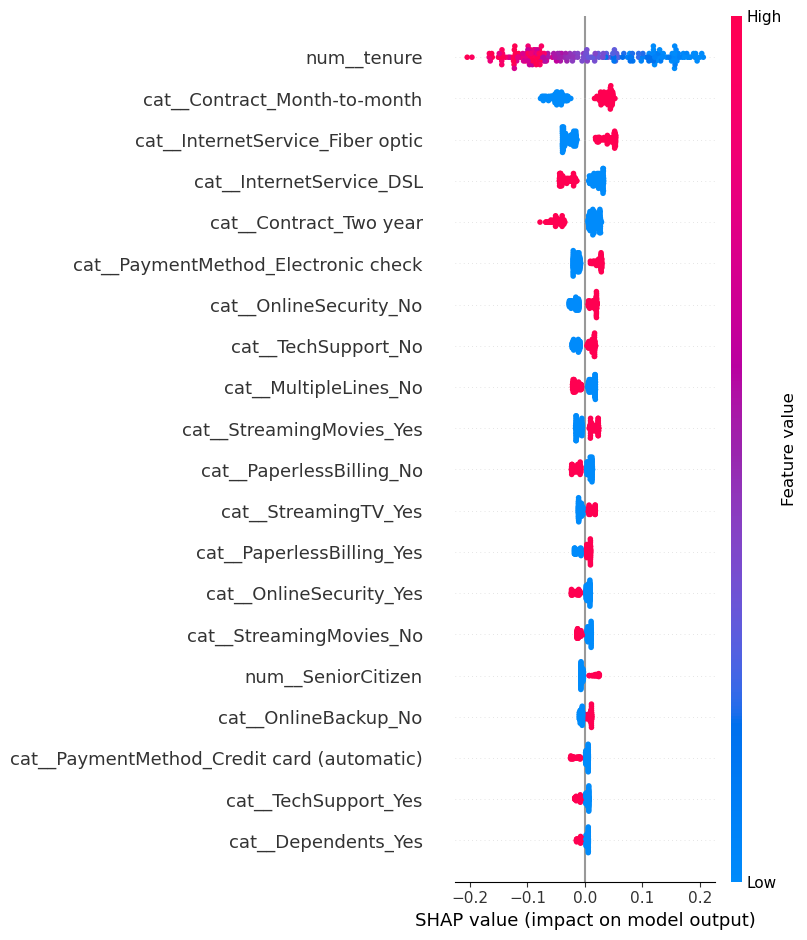

In [30]:
#plot
shap.summary_plot(shap_values[..., 1], X_explain_trans, feature_names=feature_names)

In [31]:
sv_pos = shap_values.values[:, :, 1]
sv_pos[0]

array([-6.46117571e-03,  1.41985640e-01, -9.38122917e-05, -5.16871829e-04,
       -4.13248461e-03, -3.67630934e-03, -5.08524956e-04,  3.02043098e-03,
        4.83702840e-03, -2.11717251e-03, -3.03005768e-03, -1.83704116e-02,
       -2.11783061e-03, -5.32204724e-03, -4.07605010e-02, -3.72635130e-02,
        2.59251689e-03,  1.51749257e-02,  2.56972627e-03,  7.10447157e-03,
       -8.55467870e-03,  2.67422307e-03, -3.35660860e-03,  3.00095908e-03,
        2.64522217e-03, -2.29513722e-03,  1.34424969e-02,  2.49492830e-03,
        5.52854878e-03, -6.95939665e-03,  2.74309193e-03, -1.03958421e-02,
       -1.15440824e-02,  2.68459543e-03, -1.38653914e-02,  3.46945989e-02,
       -2.91508282e-04,  1.81247700e-02, -2.10761299e-02, -1.65068340e-02,
        2.16232222e-03,  4.65144215e-03, -1.89888343e-02, -8.05770710e-03])

## Cosine similarity

In [32]:
def cosine_similarity(a, b, eps=1e-12):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + eps)

Cosine similarity returns a scalar number between -1 and 1. 

* 1.0 --> indicates identical direction of vectors, in this case explanations would be perfectly stable.

* ~0.9 --> very similar explanations

* ~0.5 --> partial agreement

* 0.0 --> unrelated explanations

* < 0 --> Opposite explanations

In this use case it indicates whether the model relies on the same features in the same way after asmall perturbation.

This should be scaled to between 1 and 0 for scoring.



## SHAP Stability

In [33]:
def shap_stability_perturbations(
    best_pipeline,
    X_train,
    X_test,
    n_background=200,
    n_samples=200,
    n_perturb=50,
    noise_level=0.02,   # 2% of train std
    class_idx=1,        # positive class
    random_state=42
):
    rng = np.random.default_rng(random_state)

    # Transform background for masker
    X_train_background_raw = shap.sample(X_train, n_background, random_state=random_state) #first sample from training data so that preprocessing is done on fewer instances

    X_train_background_feat = best_pipeline.named_steps["features"].transform(X_train_background_raw)
    X_train_background_trans = best_pipeline.named_steps["preprocess"].transform(X_train_background_feat)

    #Create Masker
    masker = shap.maskers.Independent(X_train_background_trans)

    #Define final fitted model
    model = best_pipeline.named_steps["model"]

    #Create explainer
    explainer = shap.PermutationExplainer(model.predict_proba, masker)

    # Compute SHAP for original sample
    X_explain_raw = shap.sample(X_test, n_samples, random_state=random_state)
    X_explain_feat = best_pipeline.named_steps["features"].transform(X_explain_raw)
    X_explain_trans = best_pipeline.named_steps["preprocess"].transform(X_explain_feat)

    shap_orig = explainer(X_explain_trans).values[:, :, class_idx]  # (n_samples, n_features)

    # Compute standard deviation for numeric columns 
    num_cols = X_train.select_dtypes(include="number").columns
    train_stds = X_train[num_cols].std(ddof=0).replace(0, 1e-12)

    # Perturb each sample K times, recompute SHAP, compare

    stability_scores = []

    for i in range(len(X_explain_raw)):
        x0 = X_explain_raw.iloc[i:i+1].copy() #make a copy of the sample

        # select the original shap vector for sample i
        s0 = shap_orig[i]

        similarity_scores = []

        for _ in range(n_perturb):
            x_pert = x0.copy()

            # Ensuring numerical columns are float for compatible dtype when adding noise
            x_pert[numerical_columns] = x_pert[numerical_columns].astype(float)

            # add a small amount of noise to all numeric columns at once
            noise = rng.normal(loc=0.0, scale=noise_level * train_stds.values, size=(1, len(numerical_columns)))
            x_pert.loc[:, numerical_columns] = x_pert[numerical_columns].values + noise

            # Transform perturbed sample
            x_pert_feat = best_pipeline.named_steps["features"].transform(x_pert)
            x_pert_trans = best_pipeline.named_steps["preprocess"].transform(x_pert_feat)

            # calculate shap for perturbed sample
            shap_pert = explainer(x_pert_trans).values[0, :, class_idx]

            #calculate similarity and append to list of scores
            similarity_scores.append((cosine_similarity(s0, shap_pert) + 1) / 2) # scaled for values between 0 and 1
        
        # calculate the average stability score
        stability_scores.append(np.mean(similarity_scores))
    
    return np.array(stability_scores)

In [34]:
# implementing the shap stability function

best_logreg_pipeline = results["logreg"].best_estimator_

stability = shap_stability_perturbations(
    best_logreg_pipeline,
    X_train,
    X_test,
    n_background=200,
    n_samples=200,
    n_perturb=30,
    noise_level=0.02,   
    random_state=42
)

print("Mean stability:", stability.mean())
print("Std stability:", stability.std())

Mean stability: 0.9997464456475085
Std stability: 0.0003686494830615944


## Multi-objective scoring function

Okay so we now have a SHAP stability score which can be implemented into a scoring function, that incorportates performance and shap atability.

In [35]:
def multi_objective_score(performance, SHAP_stab, perf_ratio=0.5):
    assert 0 <= performance <= 1
    assert 0 <= SHAP_stab <= 1
    assert 0 <= perf_ratio <= 1
    return perf_ratio * performance + (1-perf_ratio) * SHAP_stab

## Trying the full pipeline

In [8]:
# Importing the libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import shap

# Import the algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

In [9]:
# Import dataset
churn_data = pd.read_csv("Datasets/Telco-Customer-Churn.csv")

### Model and Hyperparameter grids

In [10]:
# Redefine models
models = {
    "logreg": LogisticRegression(),
    "dt": DecisionTreeClassifier(),
    "rf": RandomForestClassifier(),
    "svm": SVC(probability=True),
    "lgb": LGBMClassifier(),
}

# Redifine parameter space

from scipy.stats import loguniform, randint, uniform

param_grids = {
    "logreg" : [ #Not all solvers are compatible with each type of regularization. so an list of dictionaries is implemented to enforce compatibility.
        {   # liblinear: supports l1, l2
            "model__solver": ["liblinear"],
            "model__penalty": ["l1", "l2"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        {   # lbfgs: supports l2
            "model__solver": ["lbfgs"],
            "model__penalty": ["l2"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        {   # saga: supports elasticnet (needs l1_ratio)
            "model__solver": ["saga"],
            "model__penalty": ["elasticnet"],
            "model__C": loguniform(1e-4, 1e2),
            "model__l1_ratio": [0.1, 0.5, 0.9], #only used for elasticnet
            "model__class_weight": [None, "balanced"],
        },
        {   # saga can do l1 / l2 as well
            "model__solver": ["saga"],
            "model__penalty": ["l1", "l2"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        ],

    "dt" : {
        "model__max_depth": randint(1, 20), 
        "model__min_samples_split": randint(2, 20), 
        "model__min_samples_leaf": randint(1, 20),
        "model__class_weight": [None, "balanced"],
    },
    "rf" : {
        "model__n_estimators": randint(100, 500),
        "model__max_depth": randint(1, 20),
        "model__min_samples_split": randint(2, 20),
        "model__class_weight": [None, "balanced", "balanced_subsample"],
    },
    "svm" : [
        {
            "model__kernel": ["linear"],
            "model__C": loguniform(1e-3, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        {
            "model__kernel": ["rbf"],
            "model__C": loguniform(1e-3, 1e2),
            "model__gamma": ["scale", "auto"],
            "model__class_weight": [None, "balanced"],
        }
    ],
    "lgb" : {
        "model__num_leaves": randint(31, 60),       # controls tree complexity
        "model__max_depth": randint(5, 15),         # limits tree depth
        "model__learning_rate": loguniform(1e-3, 0.1), # step size
        "model__n_estimators": randint(100, 500),   # number of boosting rounds
        "model__subsample": uniform(0.7, 0.3),      # row sampling
        "model__colsample_bytree": uniform(0.7, 0.3), # feature sampling
        "model__class_weight": [None, "balanced"], # to handle class imbalance
    }
}

### Split into training and test sets

In [11]:
# Split the data into training and test sets

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(churn_data["Churn"]) # encode category labels
X = churn_data.drop("Churn", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5634, 20), (5634,), (1409, 20), (1409,))

### Group features by type, drop high cardinality

In [12]:
# Create a transformer class to group features in and drop columns

from sklearn.base import BaseEstimator, TransformerMixin

class GroupFeatures(BaseEstimator, TransformerMixin):

    # Constructor method
    def __init__(self, max_unique=20):
        self.max_unique = max_unique

    #Fit method learns column groupings and detects high cardinality --> metadata for future steps
    def fit(self, X, y=None):
        categorical = X.select_dtypes(include=["object", "string", "category"])
        numeric = X.select_dtypes(include="number")
        boolean = X.select_dtypes(include="bool")

        high_cardinality = categorical.nunique() > self.max_unique #Detects high cardinality above maximum value specified

        self.numeric_columns_ = numeric.columns.union(boolean.columns).tolist() #Creates numerical column list
        self.categorical_columns_ = high_cardinality[~high_cardinality].index.tolist() #Creates categorical column list - high cardinality features

        self.keep_columns_ = self.numeric_columns_ + self.categorical_columns_

        return self

    # passes through the data untransformed 
    def transform(self, X):
        return X[self.keep_columns_]

### Column Transformer for preprocessing

In [13]:
# ColumnTransformer for feature preprocessing
from sklearn.compose import make_column_selector

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), make_column_selector(dtype_include="number")), 
        ("cat", OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=["object", "string", "category"])),
    ],
    remainder="drop"
).set_output(transform="default")

### Hyperparameter Optimization with RandomizedSearchCV

In [14]:
# Implement RandomSearchCV test with 5 iterations

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "f1": "f1_weighted", # good for binary and multiclass classification
    "roc_auc": "roc_auc_ovr" #good for both types of classification as well.
}

results = {}

for name, model in models.items():

    # Create pipeline that include GroupFeatures in first step
    pipeline = Pipeline([
    ("features", GroupFeatures(max_unique=20)),
    ("preprocess", preprocessor),
    ("model", model)
    ])

    clf = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grids[name],
        n_iter=5,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        random_state=42,
        refit="roc_auc" #Refit an estimator using the best found parameters on the whole dataset using one main metric
    )

    search = clf.fit(X_train, y_train)

    results[name] = search

    best_idx = search.best_index_

    print("\n==============================")
    print(f"MODEL: {name}")
    print("==============================")
    print("Best Params:", search.best_params_)
    print(f"Best ROC-AUC:  {search.cv_results_['mean_test_roc_auc'][best_idx]:.4f}")
    print(f"Best Accuracy: {search.cv_results_['mean_test_accuracy'][best_idx]:.4f}")
    print(f"Best F1:       {search.cv_results_['mean_test_f1'][best_idx]:.4f}")

c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



MODEL: logreg
Best Params: {'model__C': np.float64(0.39079671568228835), 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best ROC-AUC:  0.8385
Best Accuracy: 0.7984
Best F1:       0.7915

MODEL: dt
Best Params: {'model__class_weight': None, 'model__max_depth': 4, 'model__min_samples_leaf': 8, 'model__min_samples_split': 4}
Best ROC-AUC:  0.8231
Best Accuracy: 0.7865
Best F1:       0.7710

MODEL: rf
Best Params: {'model__class_weight': None, 'model__max_depth': 7, 'model__min_samples_split': 12, 'model__n_estimators': 187}
Best ROC-AUC:  0.8381
Best Accuracy: 0.7966
Best F1:       0.7840

MODEL: svm
Best Params: {'model__C': np.float64(0.16949768237884735), 'model__class_weight': None, 'model__kernel': 'linear'}
Best ROC-AUC:  0.8340
Best Accuracy: 0.7964
Best F1:       0.7900
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can s

In [48]:
# Function for randomized search cross validation search

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline

def run_randomized_search(
    models,
    param_grids,
    X_train,
    y_train,
    preprocessor,
    feature_grouper_cls=GroupFeatures,
    feature_grouper_kwargs={"max_unique": 20},
    n_iter=5,
    n_splits=5,
    scoring=None,
    refit_metric="roc_auc",
    random_state=42,
    n_jobs=-1,
    verbose=True,
):
    """
    Runs RandomizedSearchCV for multiple models wrapped in a pipeline.

    Returns
    -------
    results : dict
        {model_name: fitted RandomizedSearchCV object}
    """

    if scoring is None:
        scoring = {
            "accuracy": "accuracy",
            "f1": "f1_weighted",
            "roc_auc": "roc_auc_ovr",
        }

    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    results = {}

    for name, model in models.items():

        pipeline = Pipeline([
            ("features", feature_grouper_cls(**feature_grouper_kwargs)),
            ("preprocess", preprocessor),
            ("model", model),
        ])

        clf = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grids[name],
            n_iter=n_iter,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs,
            random_state=random_state,
            refit=refit_metric,
        )

        search = clf.fit(X_train, y_train)
        results[name] = search

        if verbose:
            best_idx = search.best_index_

            print("\n==============================")
            print(f"MODEL: {name}")
            print("==============================")
            print("Best Params:", search.best_params_)
            print(f"Best ROC-AUC:  {search.cv_results_['mean_test_roc_auc'][best_idx]:.4f}")
            print(f"Best Accuracy:{search.cv_results_['mean_test_accuracy'][best_idx]:.4f}")
            print(f"Best F1:      {search.cv_results_['mean_test_f1'][best_idx]:.4f}")

    return results


### Evaluate model on test set

In [38]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model_on_test(best_pipeline, X_test, y_test):
    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)
    
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"), # keeping multiclass metrics
    }

    # ROC-AUC handling binary and multiclass
    n_classes = len(np.unique(y_test))
    if n_classes == 2:
        metrics["roc_auc"] = roc_auc_score(y_test, y_proba[:, 1]) # Binary
    else:
        metrics["roc_auc"] = roc_auc_score(y_test, y_proba, multi_class="ovo") # Multiclass
    
    return metrics, y_pred, y_proba

### SHAP Stability

In [18]:
def shap_stability_perturbations_binary(
    best_pipeline,
    X_train,
    X_test,
    numerical_columns,
    n_background=30, #100-200
    n_samples=50, #200-300
    n_perturb=10, # 30-50
    noise_level=0.02,   # 2% of train std
    class_idx=1,        # positive class
    random_state=42
):
    
    # Define cosine similarity inside function
    def cosine_similarity(a, b, eps=1e-12):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + eps)
    
    # Technically not needed with current model setup, however will keep for models without predict_proba
    def model_output_fn(model):
        if hasattr(model, "predict_proba"):
            return lambda X: model.predict_proba(X)[:, class_idx] # <-- for binary atm
        else:
            return model.decision_function

    rng = np.random.default_rng(random_state)

    # Extract feature names from the pipeline for future conversion of transformed arrays back into DataFrames 
    feature_names = best_pipeline.named_steps["preprocess"].get_feature_names_out()

    # Transform background data for masker
    X_train_background_raw = shap.sample(X_train, n_background, random_state=random_state) #first sample from training data so that preprocessing is done on fewer instances
    X_train_background_feat = best_pipeline.named_steps["features"].transform(X_train_background_raw)
    X_train_background_trans = best_pipeline.named_steps["preprocess"].transform(X_train_background_feat)

    #Create Masker
    masker = shap.maskers.Independent(X_train_background_trans)

    #Define final fitted model
    model = best_pipeline.named_steps["model"]
        
    #Create SHAP explainer
    explainer = shap.PermutationExplainer(model_output_fn(model), masker)

    # Prepare test samples 
    X_explain_raw = shap.sample(X_test, n_samples, random_state=random_state)
    X_explain_feat = best_pipeline.named_steps["features"].transform(X_explain_raw)
    X_explain_trans = best_pipeline.named_steps["preprocess"].transform(X_explain_feat)

    # Calculate original SHAP values
    shap_orig = explainer(X_explain_trans).values  # (n_samples, n_features)

    # Compute standard deviation for numeric columns 
    train_stds = X_train[numerical_columns].std(ddof=0).replace(0, 1e-12)

    # Perturb each sample K times, recompute SHAP, compute stability

    stability_scores = []

    for i in range(len(X_explain_raw)):
        x0 = X_explain_raw.iloc[i:i+1].copy() #make a copy of the sample

        # select the original shap vector for sample i
        s0 = shap_orig[i]

        similarity_scores = []

        for _ in range(n_perturb):
            x_pert = x0.copy()

            # Ensuring numerical columns are float for compatible dtype when adding noise
            x_pert[numerical_columns] = x_pert[numerical_columns].astype(float)

            # add a small amount of noise to all numeric columns at once
            noise = rng.normal(loc=0.0, scale=noise_level * train_stds.values, size=(1, len(numerical_columns)))
            x_pert.loc[:, numerical_columns] = x_pert[numerical_columns].values + noise

            # Transform perturbed sample
            x_pert_feat = best_pipeline.named_steps["features"].transform(x_pert)
            x_pert_trans = best_pipeline.named_steps["preprocess"].transform(x_pert_feat)

            # calculate shap for perturbed sample
            shap_pert = explainer(x_pert_trans).values[0]

            #calculate similarity and append to list of scores
            similarity_scores.append((cosine_similarity(s0, shap_pert) + 1) / 2) # scaled for values between 0 and 1
        
        # calculate the average stability score
        stability_scores.append(np.mean(similarity_scores))
    
    return np.array(stability_scores)

### Multiclass function

In [34]:
def shap_stability_perturbations(
    best_pipeline,
    X_train,
    X_test,
    numerical_columns,
    n_background=30, #100-200
    n_samples=50, #200-300
    n_perturb=10, # 30-50
    noise_level=0.02,   # 2% of train std
    random_state=42
):
    
    # Define cosine similarity inside function
    def cosine_similarity(a, b, eps=1e-12):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + eps)
    
    # Technically not needed with current model setup, however will keep for models without predict_proba
    def model_output_fn(model):
        return model.predict_proba   # returns shape: (n_samples, n_classes)

    rng = np.random.default_rng(random_state)

    # Extract feature names from the pipeline for future conversion of transformed arrays back into DataFrames 
    feature_names = best_pipeline.named_steps["preprocess"].get_feature_names_out()

    # Transform background data for masker
    X_train_background_raw = shap.sample(X_train, n_background, random_state=random_state) #first sample from training data so that preprocessing is done on fewer instances
    X_train_background_feat = best_pipeline.named_steps["features"].transform(X_train_background_raw)
    X_train_background_trans = best_pipeline.named_steps["preprocess"].transform(X_train_background_feat)

    #Create Masker
    masker = shap.maskers.Independent(X_train_background_trans)

    #Define final fitted model
    model = best_pipeline.named_steps["model"]
        
    #Create SHAP explainer
    explainer = shap.PermutationExplainer(model_output_fn(model), masker)

    # Prepare test samples 
    X_explain_raw = shap.sample(X_test, n_samples, random_state=random_state)
    X_explain_feat = best_pipeline.named_steps["features"].transform(X_explain_raw)
    X_explain_trans = best_pipeline.named_steps["preprocess"].transform(X_explain_feat)

    # Calculate original SHAP values
    shap_orig = explainer(X_explain_trans).values  # shape: (n_samples, n_features, n_classes)

    # Compute standard deviation for numeric columns 
    train_stds = X_train[numerical_columns].std(ddof=0).replace(0, 1e-12)

    # Perturb each sample K times, recompute SHAP, compute stability

    stability_scores = []

    for i in range(len(X_explain_raw)):
        x0 = X_explain_raw.iloc[i:i+1].copy() # make a copy of the sample

        # select the original shap vector for sample i
        s0 = shap_orig[i] # Shape: (n_features, n_classes)

        similarity_scores = []

        for _ in range(n_perturb):
            x_pert = x0.copy()

            # Ensuring numerical columns are float for compatible dtype when adding noise
            x_pert[numerical_columns] = x_pert[numerical_columns].astype(float)

            # add a small amount of noise to all numeric columns at once
            noise = rng.normal(loc=0.0, scale=noise_level * train_stds.values, size=(1, len(numerical_columns)))
            x_pert.loc[:, numerical_columns] = x_pert[numerical_columns].values + noise

            # Transform perturbed sample
            x_pert_feat = best_pipeline.named_steps["features"].transform(x_pert)
            x_pert_trans = best_pipeline.named_steps["preprocess"].transform(x_pert_feat)

            # calculate shap for perturbed sample
            shap_pert = explainer(x_pert_trans).values[0]

            class_similarities = []

            for c in range(s0.shape[1]):
                similarity = cosine_similarity(s0[:,c], shap_pert[:,c])
                class_similarities.append((similarity + 1) / 2) # appending class similarity to list scaled between 0 and 1
        
            similarity_scores.append(np.mean(class_similarities)) #appends mean of similarity scores across classes to similarity scores

        # calculate the average stability score
        stability_scores.append(np.mean(similarity_scores))
    
    print(f"{model.__class__.__name__} SHAP analysis complete.")
    
    return np.array(stability_scores)

In [25]:
# implementing the shap stability function for every model (multiclass or binary)

stab_scores = {}

for name in models.keys():

    best_pipeline = results[name].best_estimator_
    grouper = best_pipeline.named_steps["features"]

    numerical_columns = grouper.numeric_columns_
    categorical_columns = grouper.categorical_columns_
    keep_columns = grouper.keep_columns_

    stability = shap_stability_perturbations(
        best_pipeline,
        X_train,
        X_test,
        numerical_columns=numerical_columns,
        n_background=30,
        n_samples=50,
        n_perturb=10,
        noise_level=0.02,   
        random_state=42
        )
    
    stab_scores[name] = stability

    print(f"{name} mean stability: {stability.mean():.4f}")
    print(f"{name} std stability:  {stability.std():.4f}\n")

SHAP shape: (50, 44, 2)
logreg mean stability: 0.9998
logreg std stability:  0.0002

SHAP shape: (50, 44, 2)
dt mean stability: 0.9975
dt std stability:  0.0044

SHAP shape: (50, 44, 2)
rf mean stability: 0.9988
rf std stability:  0.0013



PermutationExplainer explainer: 51it [00:19,  1.31it/s]                        


SHAP shape: (50, 44, 2)
svm mean stability: 0.9998
svm std stability:  0.0002



c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifi

SHAP shape: (50, 44, 2)


c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifi

lgb mean stability: 0.9971
lgb std stability:  0.0019



c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifi

In [23]:
summary = pd.DataFrame({
    "model": stab_scores.keys(),
    "mean_stability": [stab_scores[m].mean() for m in stab_scores.keys()],
    "std_stability": [stab_scores[m].std() for m in stab_scores.keys()],
})

# Sort by mean stability descending
summary = summary.sort_values("mean_stability", ascending=False).reset_index(drop=True)
print("\n===== Model SHAP Stability Ranking =====")
print(summary)


===== Model SHAP Stability Ranking =====
    model  mean_stability  std_stability
0     svm        0.999826       0.000262
1  logreg        0.999805       0.000202
2      rf        0.998849       0.001344
3      dt        0.997383       0.004078
4     lgb        0.997274       0.001725


### Multi-objective scoring function

In [40]:
# define scoring function
def multi_objective_score(performance, SHAP_stab, perf_ratio=0.5):
    assert 0 <= performance <= 1
    assert 0 <= SHAP_stab <= 1
    assert 0 <= perf_ratio <= 1
    return perf_ratio * performance + (1-perf_ratio) * SHAP_stab

In [41]:
results_dict = {}

for name, search in results.items():

    best_pipeline = search.best_estimator_
    grouper = best_pipeline.named_steps["features"]

    numerical_columns = grouper.numeric_columns_
    categorical_columns = grouper.categorical_columns_
    keep_columns = grouper.keep_columns_

    metrics, y_pred, y_proba = evaluate_model_on_test(
        best_pipeline=best_pipeline,
        X_test=X_test,
        y_test=y_test)

    stability = shap_stability_perturbations(
        best_pipeline,
        X_train,
        X_test,
        numerical_columns=numerical_columns,
        n_background=30,
        n_samples=50,
        n_perturb=10,
        noise_level=0.02,   
        random_state=42
        )
    
    mean_stability = stability.mean()

    ranking_score = multi_objective_score(performance=metrics['roc_auc'], SHAP_stab=mean_stability)

    results_dict[name] = {
        "metrics": metrics,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "stability": stability,
        "mean_stability": mean_stability,
        "std_stability": stability.std(),
        "ranking_score": ranking_score
        }

LogisticRegression SHAP analysis complete.
DecisionTreeClassifier SHAP analysis complete.
RandomForestClassifier SHAP analysis complete.


PermutationExplainer explainer: 51it [00:24,  1.22it/s]                        


SVC SHAP analysis complete.


c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifi

LGBMClassifier SHAP analysis complete.


c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifi

In [42]:
results_dict['logreg']

{'metrics': {'accuracy': 0.8204400283889283,
  'f1_weighted': 0.8154163480529513,
  'roc_auc': 0.860707557423375},
 'y_pred': array([1, 0, 0, ..., 0, 0, 0], shape=(1409,)),
 'y_proba': array([[0.37673462, 0.62326538],
        [0.90554367, 0.09445633],
        [0.9906271 , 0.0093729 ],
        ...,
        [0.94585764, 0.05414236],
        [0.97705224, 0.02294776],
        [0.55768825, 0.44231175]], shape=(1409, 2)),
 'stability': array([0.99992407, 0.99996954, 0.99986045, 0.99983097, 0.99965815,
        0.99986721, 0.99986805, 0.99996245, 0.99933884, 0.99970975,
        0.99967547, 0.99995108, 0.9997239 , 0.99960838, 0.99946508,
        0.99987646, 0.9998295 , 0.99996533, 0.99860746, 0.99986449,
        0.99991745, 0.99993407, 0.99992323, 0.99992507, 0.99936661,
        0.99981499, 0.99991023, 0.99993504, 0.9997864 , 0.99992572,
        0.99991822, 0.99987234, 0.99995212, 0.99996965, 0.99989075,
        0.99995296, 0.99994258, 0.99984671, 0.99983963, 0.99996889,
        0.99996596, 0.9

In [45]:
summary = pd.DataFrame({
    "model": results_dict.keys(),
    "mean_stability": [results_dict[m]["mean_stability"] for m in results_dict.keys()],
    "std_stability": [results_dict[m]["std_stability"] for m in results_dict.keys()],
    "accuracy": [results_dict[m]["metrics"]["accuracy"] for m in results_dict.keys()],
    "f1_weighted": [results_dict[m]["metrics"]["f1_weighted"] for m in results_dict.keys()],
    "roc_auc": [results_dict[m]["metrics"]["roc_auc"] for m in results_dict.keys()],
    "ranking_score": [results_dict[m]["ranking_score"] for m in results_dict.keys()],
})

# Sort by mean stability descending
summary = summary.sort_values("ranking_score", ascending=False).reset_index(drop=True)
print("\n===== Model Summary and Scoring =====")
print(summary)


===== Model Summary and Scoring =====
    model  mean_stability  std_stability  accuracy  f1_weighted   roc_auc  \
0      rf        0.998862       0.001283  0.811923     0.802815  0.863315   
1  logreg        0.999783       0.000246  0.820440     0.815416  0.860708   
2     lgb        0.997165       0.001717  0.803407     0.786120  0.860744   
3     svm        0.999835       0.000220  0.819730     0.816144  0.856374   
4      dt        0.997374       0.005767  0.794890     0.782467  0.837847   

   ranking_score  
0       0.931089  
1       0.930245  
2       0.928955  
3       0.928105  
4       0.917610  
